# День пятый - интерпретация, внедрение и другие темы

Сегодня нас ждут:
- некоторые методы локальной интерпретации
- как создать веб-сервис на `flask`, как сохранить и загрузить модель
- презентация `jupyter notebooks` на `voila` и немного `streamlit`
- элементы мониторинга после внедрения

факультативно:
- немного о вероятностном программировании
- вариационные автокодировщики (будем генерировать картинки).

## Методы интерпретации

Как ранее уже упоминалось, методы интерпретации модели могут быть глобальными (как важность признаков у деревьев), а могут быть локальными, то есть теми, которые объясняют почему предсказание для конкретного примера именно такое.

Сейчас мы рассмотрим библиотеку `shap` (`SHapely Additive exPlanations`, где в названии, *Shapely* - это фамилия), которая такие предсказания и позволяет делать. И делает это она благодаря некоторым результатам из теории игр.

Представим себе признаки как игроков, а результат "игры" - это предсказание модели для этих признаков (разово). Тогда `shap` позволяет судить о вкладе каждого игрока в "выигрыш" (предсказание) - для этого рассматривается каждый поднабор из всех признаков (сочетания), от нуля признаков до всех. При добавлении признака в набор, он даёт некоторый вклад (эффект) в предсказание. Все эффекты для вхождений каждого признака количественно взвешиваются, они есть итоговый эффект каждого признака.

А теперь представьте что у нас (всего) 10 признаков, это означает что нам надо перебрать `2**10` моделей (с различными наборами признаков). Мы, конечно, этим заниматься не будем, и благодаря библиотеке `shap`, умеющей во всевозможные оптимизации подобных вычислений и прочие ухищрения, всё получается быстрее.

In [1]:
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загрузим датасет ракушек
data = pd.read_csv('data/abalone.csv')

# немного препроцессинга
# будем отличать только взрослых от детей!

data['sex'] = data.sex.apply(lambda sex: {
    'F': 0, 'M': 1, 'I': 2
}[sex])

data.sample(3)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
3818,1,0.565,0.445,0.14,0.836,0.406,0.1605,0.2245,9
642,0,0.590,0.450,0.16,0.900,0.358,0.1560,0.3150,19
2010,2,0.435,0.325,0.12,0.346,0.159,0.0840,0.0950,7


In [2]:
import shap

Библиотека `shap` может объяснять модели на базе деревьев (`TreeExplainer`), линейные (`LinearExplainer`, требуются независимые - они же несвязанные - признаки), нейронные сети `keras` (`DeepExplainer`), а также произвольные модели (`KernelExplainer`) - но увы весьма медленно.

На данный момент, `TreeExplainer` не умеет в мультикласс, поэтом в этих случаях надо пользоваться универсальным `KernelExplainer`, и следует отметить, что он требует чтобы у модели был метод `predict_proba` (предсказывает вероятность - или уверенность - в классе). Таким методом обладают, например, все деревья.

Мы же пока тем временем попробуем объяснить результаты работы регрессора.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

# отложим 100 сэмплов
indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-100]
test = indices[-100:]

regressor = GradientBoostingRegressor(
    n_estimators=15, max_depth=7, random_state=1
).fit(data.iloc[train,:-1], data.iloc[train, -1])

print("test score %.3f" % regressor.score(
    data.iloc[test,:-1], data.iloc[test, -1]
))

explainer = shap.TreeExplainer(regressor, data=data.iloc[test, :-1])
shap_values_test = explainer.shap_values(data.iloc[test, :-1]);

test score 0.361


In [4]:
print('True rings value for first test sample = %d' % data.iloc[test[0], -1])

True rings value for first test sample = 11


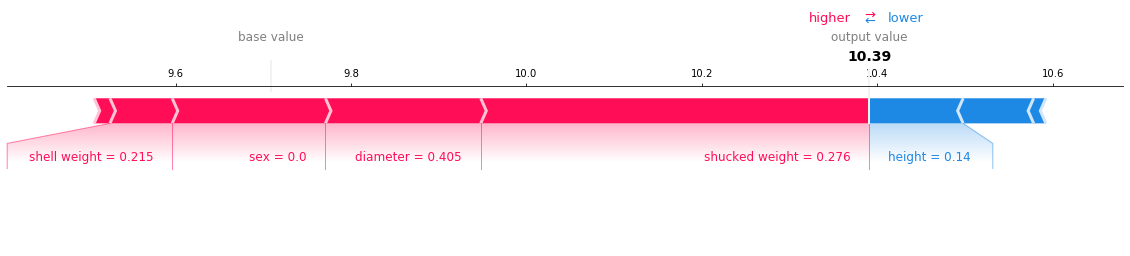

In [5]:
shap.force_plot(explainer.expected_value, shap_values_test[0], data.iloc[test[0],:-1], matplotlib=True)

На это диаграмме красным - то что добавило нам колец, а синим - то, что (для этой ракушки) убавило. Причем подписано сколько колец добавлено/убавлено. Лично я считаю, что для регрессии подобные объяснения очень наглядны. 

Для классификации есть же нечто, скажем так, поинтереснее, а именно `Alibi Trust Scores` - уровни доверия. Это мера соответствия между предсказанным классом, и тем, какие ближайшие соседи у этого класса. Условно, если предсказанный класс примера находится рядом с множеством подобных - тем больше мы можем верить предсказанию. А если не условно, то это по аналогии с `silhoutte_score` - отношение между расстоянием до ближайшего класса, отличного от предсказанного, к расстоянию до предсказанного класса. Следовательно, если эта величина больше 1, и чем она вообще больше, тем больше доверия к предсказанию.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(
    n_estimators=15, max_depth=3, random_state=1
).fit(data.iloc[train,1:], data.iloc[train, 0])

print("test score %.3f" % classifier.score(
    data.iloc[test,1:], data.iloc[test, 0]
))

test score 0.580


In [7]:
from alibi.confidence import TrustScore
ts = TrustScore(
    # тут могут быть настройки, но мы
    # оставим всё по умолчанию
)

ts.fit(
    data.iloc[train,1:].values,
    data.iloc[train, 0].values,
    classes=3
)

In [8]:
predicted = classifier.predict([data.iloc[test[0], 1:]])[0]
print("True class %d, predicted %d" % (
    data.iloc[test[0], 0],
    predicted
))

trust_scores, closest_classes = ts.score(
    np.array([data.iloc[test[0], 1:]]),
    np.array([predicted])
)

print("Proba %.3f, TrustScore %.3f, closest class %d" % (
    classifier.predict_proba(
        data.iloc[test[0], 1:].values.reshape(1, -1)
    )[0][0],
    trust_scores[0], closest_classes[0]
))

True class 0, predicted 2
Proba 0.330, TrustScore 0.745, closest class 0


Тут видим, `trust score < 1` , и ближайший класс точнее. Впрочем, здесь и вероятность предсказания не самая высокая (да и классификатор так себе).

А сейчас мы рассмотрим технику, которая позволяет одновременно отбирать признаки и строить некоторую интерпретацию вида "мы тут можем ошибаться на столько-то" (*model perfomance prediction*). Нужно построить регрессор (в случае классификации - классификатор), который будет обучен (на отложенной валидации, поскольку стэкинг) предсказывать ошибки алгоритма.

Посмотрим на эту позаимствованную (получается уже трижды) картинку.
![MPP](media/mpp.png)

In [9]:
# data = pd.read_csv('data/abalone.csv')
# data = pd.get_dummies(data.sex).join(data.drop('sex', axis='columns'))

indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-1000]
val = indices[-1000:-500]
test = indices[-500:]

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.pipeline import make_pipeline

preprocessor_regression = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_regression_train = preprocessor_regression.fit_transform(data.iloc[train,1:-1])
X_regression_val = preprocessor_regression.transform(data.iloc[val,1:-1])
X_regression_test = preprocessor_regression.transform(data.iloc[test,1:-1])

preprocessor_classification = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_classification_train = preprocessor_classification.fit_transform(data.iloc[train,1:])
X_classification_val = preprocessor_classification.transform(data.iloc[val,1:])
X_classification_test = preprocessor_classification.transform(data.iloc[test,1:])

regressor = Ridge(random_state=1).fit(
    X_regression_train, data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train, data.iloc[train, 0]
)

print("simple: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test, data.iloc[test, -1]),
    classifier.score(X_classification_test, data.iloc[test, 0])
))

simple: r2 0.497, acc 0.540


In [10]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

def get_error_models(regression_features, classifier_features):
    error_regressor = GradientBoostingRegressor(
        n_estimators=30, max_depth=3, random_state=1
    ).fit(
        X_regression_val[:, regression_features],
        np.abs(
            regressor.predict(X_regression_val[:, regression_features]) - data.iloc[val,-1]
        )
    )

    error_classifier = GradientBoostingClassifier(
        n_estimators=30, max_depth=3, random_state=1
    ).fit(
        X_classification_val[:, classifier_features],
        (
            classifier.predict(X_classification_val[:, classifier_features]) != data.iloc[val,0]
        ).astype(int)
    )
    return error_regressor, error_classifier

error_regressor, error_classifier = get_error_models(
    regression_features=slice(None),
    classifier_features=slice(None)
)

Мы получили регрессор ошибки и классификатор ошибки. Их можно использовать и для отбора признаков (в обоих случаях уберем несколько неважных признаков и посмотрим), и для проверки корректности предсказания.

In [11]:
redundand = 40

regressor_features = np.argsort(error_regressor.feature_importances_)[redundand:]
classifier_features = np.argsort(error_classifier.feature_importances_)[redundand:]

regressor = Ridge(random_state=1).fit(
    X_regression_train[:, regressor_features], 
    data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train[:, classifier_features],
    data.iloc[train, :1]
)

print("selected: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test[:, regressor_features], data.iloc[test, -1]),
    classifier.score(X_classification_test[:, classifier_features], data.iloc[test,0])
))

selected: r2 0.512, acc 0.556


В данном случае мы убрали признаки, которые давали *наименьший вклад в объяснение ошибки*. Это означает, что они имеют слабое влияния на то, как предсказывает изначальная модель. Давайте посмотрим на ошибку предсказания для конкретного примера.

In [12]:
error_regressor, error_classifier = get_error_models(
    regressor_features, classifier_features
)

print("regression: True %d, Predicted %.2f, error %.3f" % (
    data.iloc[test[0], -1],
    regressor.predict([X_regression_test[0, regressor_features]])[0],
    error_regressor.predict([X_regression_test[0, regressor_features]])[0]
))

print("classification: True %s, Predicted %s, is error %s" % (
    str(data.iloc[test[0], 0].astype(int)),
    str(classifier.predict([X_classification_test[0, classifier_features]])[0]),
    str(error_classifier.predict([X_classification_test[0, classifier_features]])[0])
))

regression: True 8, Predicted 9.58, error 1.220
classification: True 2, Predicted 1, is error 1


## В качестве заключения

Не всегда модели всё делают автоматически (вместо людей). Часто, и особенно на сложных производствах - модели лишь рекомендуют некоторый режим или настройки технологических процессов. И когда человек принимает решение в конкретный момент времени, ему хотелось бы знать, почему именно такое предсказание выдала модель, потому что "черным ящикам" не доверяют - несмотря на все метрики и кросс-валидации (так устроен человек). Поэтому если есть объяснение предсказанию, или степень уверенности - это важная дополнительная информация для человека, который будет принимать решение.